In [93]:
import numpy as np 
import pandas as pd
import os
import sys
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [94]:
BASE_DIR = "../../../data/pc_game"


In [95]:
df_train = pd.read_csv(BASE_DIR + '/train.csv')
df_test = pd.read_csv(BASE_DIR + '/test.csv')
df_sub = pd.read_csv(BASE_DIR + '/sample_submit.csv',header=None)

In [96]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [97]:
df_test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


In [98]:
df_sub

,0,1
0,9,0
1,15,0
2,18,0
3,23,0
4,31,0
...,...,...
1995,9971,0
1996,9980,0
1997,9983,0
1998,9996,0


In [99]:
col_li = df_train.columns.tolist()
feature_col = df_test.columns.tolist()
df_train['blueWins'].value_counts()

0    4066
1    3934
Name: blueWins, dtype: int64

In [100]:
df_train.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


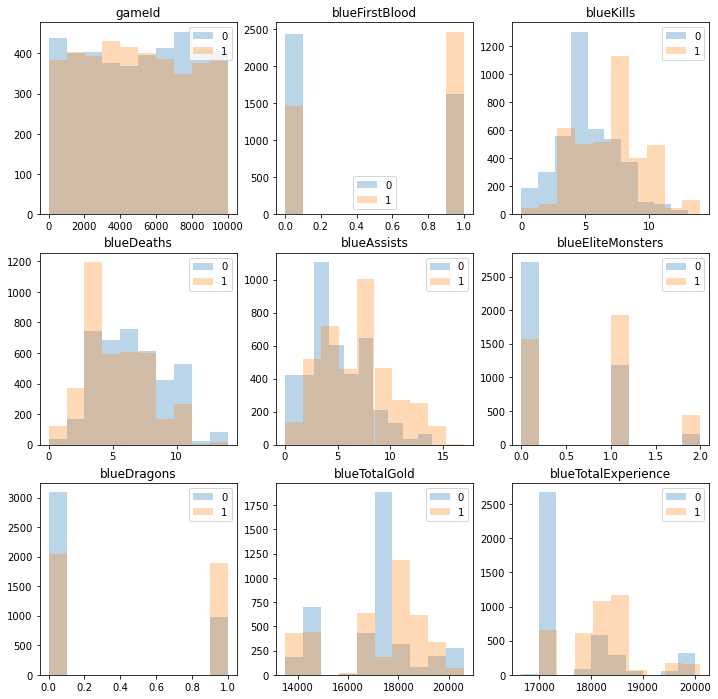

In [101]:
plt.figure(figsize=(12,12))
for i in range(len(feature_col)):
    plt.subplot(3,3,i+1)
    plt.hist(df_train[df_train['blueWins']==0][feature_col[i]],label='0',alpha=0.3)
    plt.hist(df_train[df_train['blueWins']==1][feature_col[i]],label='1',alpha=0.3)
    plt.legend()
    plt.title(feature_col[i])
plt.show()

In [102]:
df_train['blueKills/blueDeath'] = df_train['blueKills'] / (df_train['blueDeaths']+1)
df_test['blueKills/blueDeath'] = df_test['blueKills'] / (df_test['blueDeaths']+1)

In [103]:
df_train.groupby('blueDragons')['blueWins'].value_counts()

blueDragons  blueWins
0            0           3093
             1           2042
1            1           1892
             0            973
Name: blueWins, dtype: int64

In [104]:
df_train.corr()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueKills/blueDeath
gameId,1.000000,-0.001356,0.015867,0.011907,0.013440,0.001194,0.001223,0.012690,-0.000432,-0.014944,-0.009867
blueFirstBlood,-0.001356,1.000000,0.283559,-0.325833,0.241781,0.213862,0.155051,-0.111157,0.033651,0.226536,0.274864
blueKills,0.015867,0.283559,1.000000,-0.079929,0.710046,0.246184,0.196728,0.099387,0.309264,0.337541,0.563008
blueDeaths,0.011907,-0.325833,-0.079929,1.000000,-0.060368,-0.223138,-0.180798,0.060901,-0.051879,-0.237224,-0.525727
blueAssists,0.013440,0.241781,0.710046,-0.060368,1.000000,0.213466,0.176668,0.108863,0.301567,0.311647,0.363470
blueEliteMonsters,0.001194,0.213862,0.246184,-0.223138,0.213466,1.000000,0.787022,0.149436,0.295139,0.272810,0.206812
blueDragons,0.001223,0.155051,0.196728,-0.180798,0.176668,0.787022,1.000000,0.185465,0.295516,0.251957,0.166233
blueTotalGold,0.012690,-0.111157,0.099387,0.060901,0.108863,0.149436,0.185465,1.000000,0.162229,0.040489,0.048147
blueTotalExperience,-0.000432,0.033651,0.309264,-0.051879,0.301567,0.295139,0.295516,0.162229,1.000000,0.328167,0.170345
blueWins,-0.014944,0.226536,0.337541,-0.237224,0.311647,0.272810,0.251957,0.040489,0.328167,1.000000,0.266135


In [105]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,blueKills/blueDeath
0,0,0,5,8,6,0,0,14536,17256,0,0.555556
1,1,1,10,1,5,0,0,14536,17863,0,5.000000
2,2,0,3,10,2,0,0,17409,17256,0,0.272727
3,3,1,7,10,8,0,0,19558,18201,0,0.636364
4,4,0,4,9,4,0,0,17409,17256,0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1,1.285714
7996,9994,0,3,10,4,0,0,17381,19797,0,0.272727
7997,9995,1,9,3,9,2,1,18274,18491,1,2.250000
7998,9997,0,5,10,6,1,1,18274,18491,1,0.454545


In [106]:
int_li = ['blueFirstBlood','blueKills','blueDeaths','blueAssists','blueEliteMonsters','blueDragons','blueTotalGold','blueTotalExperience']
for i in range(0,4,1):
    for j in range(4,len(int_li),1):
        col_name = int_li[i] + '__' + int_li[j]
        df_train[col_name] = df_train[col_li[i]] * df_train[col_li[j]]
        df_test[col_name] = df_test[col_li[i]] * df_test[col_li[j]]

In [107]:
df_train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
0,0,0,5,8,6,0,0,14536,17256,0,...,0,0,30,0,0,72680,48,0,0,116288
1,1,1,10,1,5,0,0,14536,17863,0,...,0,14536,50,0,0,145360,5,0,0,14536
2,2,0,3,10,2,0,0,17409,17256,0,...,0,0,6,0,0,52227,20,0,0,174090
3,3,1,7,10,8,0,0,19558,18201,0,...,0,19558,56,0,0,136906,80,0,0,195580
4,4,0,4,9,4,0,0,17409,17256,0,...,0,0,16,0,0,69636,36,0,0,156681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1,...,0,18513,126,0,0,166617,84,0,0,111078
7996,9994,0,3,10,4,0,0,17381,19797,0,...,0,0,12,0,0,52143,40,0,0,173810
7997,9995,1,9,3,9,2,1,18274,18491,1,...,1,18274,81,18,9,164466,27,6,3,54822
7998,9997,0,5,10,6,1,1,18274,18491,1,...,0,0,30,5,5,91370,60,10,10,182740


In [108]:
df_test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueKills/blueDeath,...,blueKills__blueTotalGold,blueKills__blueTotalExperience,blueDeaths__blueEliteMonsters,blueDeaths__blueDragons,blueDeaths__blueTotalGold,blueDeaths__blueTotalExperience,blueAssists__blueEliteMonsters,blueAssists__blueDragons,blueAssists__blueTotalGold,blueAssists__blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201,1.000000,...,0,0,42,0,0,118727,36,0,0,101766
1,15,0,6,6,6,2,1,18513,18021,0.857143,...,0,0,36,12,6,111078,36,12,6,111078
2,18,1,6,4,3,0,0,13475,17256,1.200000,...,0,13475,18,0,0,80850,12,0,0,53900
3,23,0,5,4,7,0,0,17409,17256,1.000000,...,0,0,35,0,0,87045,28,0,0,69636
4,31,0,10,8,9,0,0,18117,18472,1.111111,...,0,0,90,0,0,181170,72,0,0,144936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256,1.500000,...,0,0,42,0,0,104454,21,0,0,52227
1996,9980,0,4,4,4,0,0,17409,17256,0.800000,...,0,0,16,0,0,69636,16,0,0,69636
1997,9983,1,6,3,3,1,1,18513,18201,1.500000,...,1,18513,18,6,6,111078,9,3,3,55539
1998,9996,1,10,9,9,1,1,18513,18201,1.000000,...,1,18513,90,10,10,185130,81,9,9,166617


In [109]:
X = df_train.drop(columns=['gameId','blueTotalGold','blueWins'])
y = df_train['blueWins']

z = df_test.drop(columns=['gameId','blueTotalGold'])

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [87]:
parameters = {'max_depth':[5,6], 'n_estimators':[1000,2000,3000]}
clf = RandomForestClassifier()
cv = GridSearchCV(clf, parameters)
cv.fit(X_train, y_train)
clf = cv.best_estimator_
clf.score(X_test,y_test)

0.75

In [88]:
clf.score(X_train,y_train)

0.7801666666666667

In [70]:
cv.best_params_

{'max_depth': 8, 'n_estimators': 1000}

In [71]:
clf.feature_importances_

array([0.00681325, 0.03987216, 0.03068204, 0.02304046, 0.01248156,
       0.00293532, 0.2902352 , 0.02759188, 0.00430141, 0.09992957,
       0.04890892, 0.02550236, 0.09464304, 0.02520973, 0.00954902,
       0.07287432, 0.0258057 , 0.033451  , 0.01618447, 0.03076877,
       0.0112815 , 0.04924791, 0.01869041])

In [158]:
clf = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=16,
    min_child_samples=20,
    max_depth=4,
    n_estimators=1000
)
clf.fit(X_train, y_train)

LGBMClassifier(max_depth=4, n_estimators=1000, num_leaves=16,
               objective='binary')

In [160]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.7805


In [167]:
(y_pred==y_test).sum()/len(y_test)

0.7805

In [162]:
df_sub[1] = y_pred

In [72]:
pre = clf.predict(z)

In [73]:
df_sub[1] = pre

In [163]:
df_sub.to_csv(BASE_DIR+'/subbmission.csv',header=None,index=False)